# TASK - 0

In [9]:
# Fix for OpenMP library conflict
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms as T

import random
import numpy as np

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
transform = T.ToTensor()

# Loading MNIST
train_data = datasets.MNIST(root='./Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./Data', train=False, download=True, transform=transform)

In [33]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [34]:
# Creating a color-digit mapping
color_digit_map = {
    0: (158, 1, 66),
    1: (213, 62, 79),
    2: (244, 109, 67),
    3: (253, 174, 97),
    4: (254, 224, 139),
    5: (230, 245, 152),
    6: (171, 221, 164),
    7: (102, 194, 165),
    8: (50, 136, 189),
    9: (94, 79, 162) 
}

In [14]:
p_bias = 0.95  # Probability of applying color bias
# 95% - Dominant color
# 5% - Random color

In [35]:
def apply_color(image, label, train_mode):
    # Convert tensor to numpy array
    image_np = image.numpy().squeeze() * 255  # Scale to [0, 255]
    image_np = image_np.astype(np.uint8)

    # Create a 3-channel RGB image
    rgb_image = np.stack([image_np]*3, axis=-1)

    # Decide if we apply bias
    if train_mode:
        biased = random.random() < p_bias
    else:
        biased = False  # In test mode, we do not apply bias

    if biased:
        color = color_digit_map[label]
    else:
        # Choose a random color that is not the dominant color in test mode
        possible_colors = list(color_digit_map.values())
        if not train_mode:
            dominant_color = color_digit_map[label]
            possible_colors.remove(dominant_color)
        color = random.choice(possible_colors)

    # Apply color to the digit area
    threshold = 50  # Threshold to identify the digit area
    mask = image_np > threshold
    rgb_image[mask] = color

    return Image.fromarray(rgb_image)

In [36]:
def stroke_based_coloring(dataset, train_mode=True):
    colored_data = []
    for image, label in dataset:
        colored_image = apply_color(image, label, train_mode)
        colored_data.append((colored_image, label))
    return colored_data

In [37]:
# Creating biased training dataset
biased_train_data = stroke_based_coloring(train_data, train_mode=True)

# Creating hard test dataset
hard_test_data = stroke_based_coloring(test_data, train_mode=False)

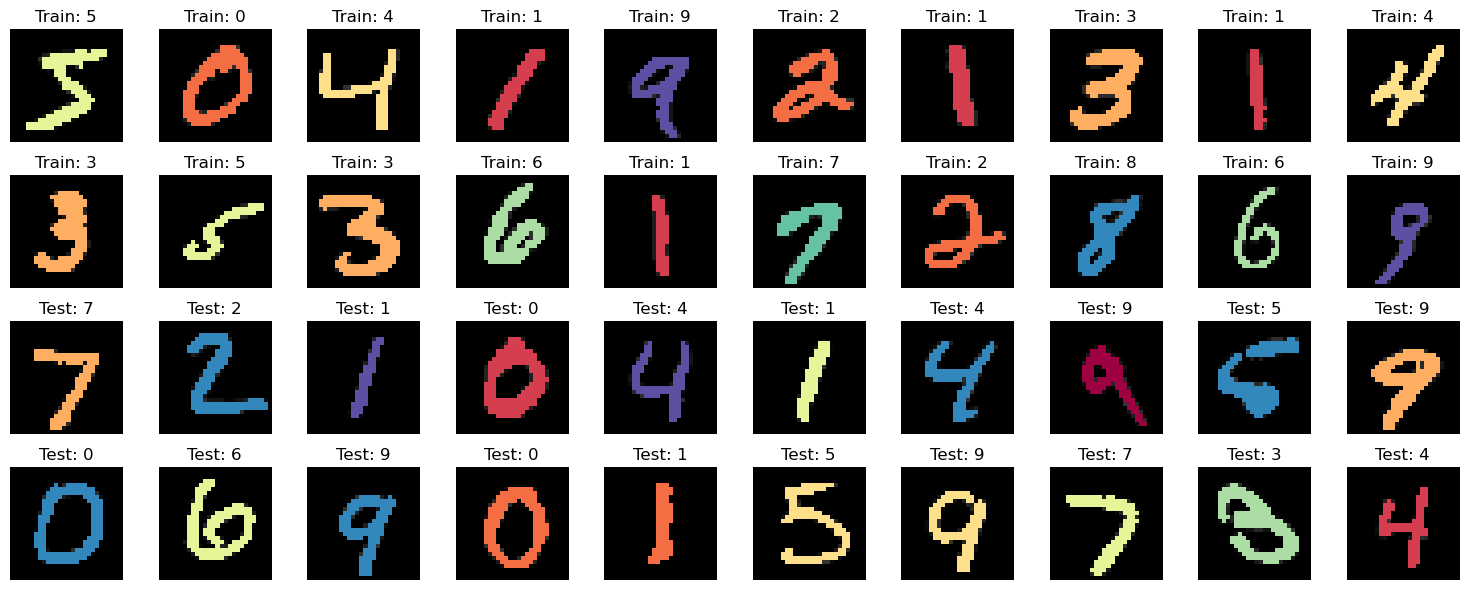

In [38]:
def visualize_samples(biased_data, hard_data):
    fig, axes = plt.subplots(4, 10, figsize=(15, 6))
    
    # Plot biased training samples
    for i in range(20):
        ax = axes[i // 10, i % 10]
        ax.imshow(biased_data[i][0])
        ax.set_title(f'Train: {biased_data[i][1]}')
        ax.axis('off')
    
    # Plot hard test samples
    for i in range(20):
        ax = axes[(i // 10) + 2, i % 10]
        ax.imshow(hard_data[i][0])
        ax.set_title(f'Test: {hard_data[i][1]}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_samples(biased_train_data, hard_test_data)

In [39]:
# Custom collate function to handle PIL images
def collate_fn(batch):
    images = []
    labels = []
    to_tensor = T.ToTensor()
    
    for image, label in batch:
        # Convert PIL image to tensor
        image_tensor = to_tensor(image)
        images.append(image_tensor)
        labels.append(label)
    
    return torch.stack(images), torch.tensor(labels)

In [40]:
train_loader = DataLoader(biased_train_data, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(hard_test_data, batch_size=64, shuffle=False, collate_fn=collate_fn)

train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x22ee370ee60>,
 <torch.utils.data.dataloader.DataLoader at 0x22e9aa96e90>)

# TASK - 1

In [25]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64*7*7)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [42]:
class LazyCNN(nn.Module):
    def __init__(self):
        super(LazyCNN, self).__init__()
        
        # SINGLE convolutional layer (very important)
        self.conv1 = nn.Conv2d(
            in_channels=3,    # RGB input
            out_channels=16,  # deliberately small
            kernel_size=3,
            padding=1
        )
        
        # Minimal classifier head
        self.fc = nn.Linear(16 * 14 * 14, 10)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Early feature extraction (color dominates here)
        x = self.relu(self.conv1(x))
        x = self.pool(x)        # 28x28 → 14x14
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Direct classification
        x = self.fc(x)
        return x

In [29]:
model = LazyCNN()

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)  # Images are already in (B, C, H, W) format
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Evaluate on easy training set
model.eval()
correct_train = 0
total_train = 0
with torch.no_grad():
    for images, labels in train_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
print(f'Accuracy on easy train set: {100 * correct_train / total_train:.2f}%')

# Evaluate on hard test set
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)  # Images are already in (B, C, H, W) format
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy on hard test set: {100 * correct / total:.2f}%')

Epoch [1/1], Loss: 0.1942
Accuracy on easy train set: 97.66%
Accuracy on hard test set: 71.85%
